In [46]:
import pandas as pd
import numpy as np
import talib
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def formatBacktestdata(_ccy:str):
    # Formatting
    _tarCol = ['Open time', 'Open', 'High', 'Low', 'Volume', 'Close']
    _Dir = "C:\\Users\\LCYY\\Desktop\\CrytoTrade\\Data\\Binance\\"
    _filename = '{}USDT.csv'.format(_ccy)
    _histData = pd.read_csv(_Dir + _filename, dtype={'Open time':str})[_tarCol].dropna()
    _histData['datetime'] = pd.to_datetime(_histData['Open time'], format='%Y-%m-%d %H:%M:%S')
    _histData = _histData.sort_values('datetime').reset_index(drop=True)
    _histData['date'] = _histData.datetime.dt.date
    _histData['time'] = _histData.datetime.dt.time
    _histData['symbol'] = _ccy + '/' + 'USDT'
    _histData = _histData[['datetime', 'date', 'time', 'symbol'] + _tarCol]
    _histData = _histData.drop(columns=['Open time'], axis=1)
    return _histData

In [3]:
def getRandomPeriod(_date:list, _numDays:int):
    _minDate = datetime.date(2020, 12, 31)
    _maxDate = datetime.date(2021, 10, 31)
    _startPeriod = random.choice(_date)
    _endPeriod = _startPeriod + datetime.timedelta(days=_numDays)
    if (_startPeriod >= _minDate) and (_endPeriod <= _maxDate) :
        return _startPeriod, _endPeriod
    else:
        return getRandomPeriod(_date, _numDays)

In [4]:
def calRSI(_close:pd.Series, _window_length:int,_mode:str):
    delta = _close.diff()[1:]
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()
    if _mode == 'EWMA':
        # Calculate the RSI based on EWMA
        roll_up = up.ewm(span=_window_length).mean()
        roll_down = down.ewm(span=_window_length).mean()
    elif _mode == 'SMA':
        # Calculate the RSI based on SMA
        roll_up = up.rolling(_window_length).mean()
        roll_down = down.rolling(_window_length).mean()
    elif _mode == 'RMA':
        # Calculate the RSI based on RMA/SMMA/MMA
        alpha = 1 / _window_length
        roll_up = up.ewm(alpha=alpha).mean()
        roll_down = down.ewm(alpha=alpha).mean()
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return pd.concat([pd.Series([0]), rsi])

In [5]:
def calSTOSC(_sto:pd.Series, _window_length:int):
    # Stochastic
    _SOSC = []
    for i in range(len(_sto)-_window_length):
        _lookbackPeriod = _sto[i:i+_window_length]
        _localmin, _localmax = _lookbackPeriod.min(), _lookbackPeriod.max()
        if _localmax - _localmin == 0:
            _SOSC.append(0)
        else:
            _SOSC.append((_sto[i] - _localmin)/(_localmax - _localmin)*100)
    _SOSC = pd.Series([0]*_window_length + _SOSC)
    return _SOSC

In [6]:
def calFastSlowK(_sto:pd.Series, _high:pd.Series, _low:pd.Series, _window_length:int, _smoother:int):
    # Stochastic Oscillator
    _localHigh = _high.rolling(_window_length).max()
    _localLow = _low.rolling(_window_length).min()
    _FastK = (_sto - _localLow) * 100 / (_localHigh - _localLow)
    _SlowK = _FastK.rolling(_smoother).mean()
    return _FastK, _SlowK

In [7]:
def calEMA(_close:pd.Series, _window_length:int):
    return _close.ewm(span=_window_length).mean()

In [8]:
def calMACD(_close:pd.Series, _windowK:int, _windowD:int, _windowS:int):
    _kLine = _close.ewm(span=_windowK).mean()
    _dLine = _close.ewm(span=_windowD).mean()
    _macd = _kLine-_dLine
    _macd_s = _macd.ewm(span=_windowS).mean()
    _histo = _macd - _macd_s
    return _macd, _macd_s, _histo

In [9]:
def calSuperTrend(_close:pd.Series, _high:pd.Series, _low:pd.Series, _window_length:int, _multiplier:int):
    # Close cross above SuperTrend = Buy
    # ATR
    TRHL = pd.DataFrame(_high - _low)
    TRHC = pd.DataFrame(abs(_high - _close.shift(1)))
    TRLC = pd.DataFrame(abs(_low - _close.shift(1)))
    TR = pd.concat([TRHL, TRHC, TRLC], axis = 1, join = 'inner').max(axis = 1)
    ATR = TR.ewm(_window_length).mean()
    # H/L AVG AND BASIC UPPER & LOWER BAND
    HLA = (_high + _low) / 2
    BUB = (HLA + _multiplier * ATR).dropna()
    BLB = (HLA - _multiplier * ATR).dropna()
    # FINAL BANDS
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in BUB - BUB]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
            final_bands.iloc[i, 1] = 0
        else:
            # UPPER
            if (BUB[i] < final_bands.iloc[i-1,0]) | (_close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = BUB[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
            # LOWER
            if (BLB[i] > final_bands.iloc[i-1,1]) | (_close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = BLB[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    # SUPERTREND
    supertrend = pd.DataFrame(columns = [f'supertrend_{_window_length}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and _close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and _close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and _close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and _close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    supertrend = supertrend.set_index(BUB.index)
    supertrend = supertrend.dropna()[1:]
    return pd.Series(supertrend.iloc[:, 0])

In [10]:
def Strat_Volume(_N_volume:float, _threshold:float):
    return 1 if _N_volume >= _threshold else 0

def Strat_FastSlowK(_fastK:float, _slowK:float, _thes:int):
    if ((_fastK < _thes) and (_slowK < _thes) and (_fastK > _slowK)):
        return 1
    elif ((_fastK > (100-_thes)) and (_slowK < (100-_thes)) and (_fastK < _slowK)):
        return -1
    else:
        return 0
    
def Strat_KDSwing(_fastK:float, _slowK:float, _thes:int):
    if ((_fastK < _thes) and (_slowK < _thes) and (abs(_fastK/_slowK-1) < 0.02)):
        return 1
    elif ((_fastK > (100-_thes)) and (_slowK < (100-_thes)) and (abs(_fastK/_slowK-1) < 0.02)):
        return -1
    else:
        return 0
    
def Strat_MACD(_macd:float, _macdS:float, _NmacdH:float):
    if (_macd > _macdS) and (_NmacdH > 0.75):
        return 1
    elif _macd < _macdS and (_NmacdH <= 0.25):
        return -1
    else:
        return 0
    
def Strat_BullishOversold(_close:float, _EMA:float, _ST:float, _SRSI:float, _SOS:float):
    return 1 if (((_SRSI+_SOS)/2 < 20) and ((_close > _EMA) or (_close > _ST))) else 0

def Strat_APO(_APO:pd.Series):    
    #Absolute price oscillator 
    #Buy when APO cross from 0 to +ve
    stoch_signal = []
    signal = 0
    for i in range(len(_APO)):
        if _APO[i] > 0:
            if signal != 1:
                signal = 1
                stoch_signal.append(signal)
            else:
                stoch_signal.append(0)
        elif _APO[i] <= 0:
            if signal != 0:
                signal = 0
                stoch_signal.append(0)
            else:
                stoch_signal.append(0)
        else:
            stoch_signal.append(0)
    return stoch_signal

#Aroon
#IF AROON UP LINE => 70 AND AROON DOWN LINE <= 30 --> BUY SIGNAL
#IF AROON UP LINE <= 30 AND AROON DOWN LINE >= 70 --> SELL SIGNAL
def Strat_AROON(_AROONUP:pd.Series, _AROONDown:pd.Series):
    aroon_signal = []
    signal = 0
    for i in range(len(_AROONUP)):
        if _AROONUP[i] >= 70 and _AROONDown[i] <= 30:
            if signal != 1:
                signal = 1
                aroon_signal.append(signal)
            else:
                aroon_signal.append(0)
        elif _AROONUP[i] <= 30 and _AROONDown[i] >= 70:
            if signal != -1:
                signal = -1
                aroon_signal.append(signal)
            else:
                aroon_signal.append(0)
        else:
            aroon_signal.append(0)
    return aroon_signal

#Money flow index
#MFI < 20 then Buy
def Strat_MFI(_MFI):
    MFI_signal = []
    signal = 0
    for i in range(len(_MFI)):
        if _MFI[i] < 20:
            if signal != 1:
                signal = 1
                MFI_signal.append(signal)
            else:
                MFI_signal.append(0)
        elif _MFI[i] >= 0:
            if signal != 0:
                signal = 0
                MFI_signal.append(0)
            else:
                MFI_signal.append(0)
        else:
            MFI_signal.append(0)
    return MFI_signal

In [11]:
def Gen_backtesting_data(_ccy:str):
    # Load data
    _data = formatBacktestdata(_ccy)
    _startDate, _endDate = getRandomPeriod(_date=_data.date.unique(), _numDays=180)
    _train = _data[(_data.date >= _startDate) & (_data.date <= _endDate)].reset_index(drop=True)
    _test = _data[(_data.date >= datetime.date(2021, 10, 31))].reset_index(drop=True)
#     for data in [_train, _test]:
#         # Normalization
# #         data['SOS'] = calSTOSC(_sto=data['Close'], _window_length=14)
# #         data['SFastK'], data['SSlowK'] = calFastSlowK(_sto=data['Close'], _high=data['High'], _low=data['Low'], \
# #                                                       _window_length=14, _smoother=3)
# #         data['RSI'] = calRSI(data['Close'], _window_length=14, _mode='EWMA')
# #         data['SRSI'] = calSTOSC(_sto=data['RSI'], _window_length=14)
# #         data['SVOL'] = calSTOSC(_sto=data['Volume'], _window_length=14)
# #         data['ST'] = calSuperTrend(_close=data['Close'], _high=data['High'], 
# #                                    _low=data['Low'], _window_length=14, _multiplier=3)
# #         data['MACD'], data['MACD_SLine'], data['MACD_Hist'] = calMACD(_close=data['Close'], _windowK=12, \
# #                                                                 _windowD=26, _windowS=9)
# #         data['N_MACD_Hist'] = ((data.MACD_Hist - data.MACD_Hist.min())/(data.MACD_Hist.max() - data.MACD_Hist.min()))
# #         data['APO'] = talib.APO(data.Close, fastperiod = 4, slowperiod = 6, matype = 0)
# #         data['AROONDown'], data['AROONUP'] = talib.AROON(data['High'], data['Low'], timeperiod=14)
# #         data['MFI'] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=14)
    return _train, _test

In [12]:
def Gen_backtesting_signal(_data:pd.DataFrame):
    # Signal
    _signaldf = pd.DataFrame(data=[x for x in _data.date], columns=['date'])
    _signaldf['time'] = _data.time
    # Volume
    for _vlag in [0, 1, 2, 3, 4, 5]:
        _data['MinMaxVolume_LAG_{}'.format(_vlag)] = ((_data.Volume - _data.Volume.min()) / \
                                          (_data.Volume.max() - _data.Volume.min())).shift(_vlag)
        _limit = _data['MinMaxVolume_LAG_{}'.format(_vlag)].mean() + _data['MinMaxVolume_LAG_{}'.format(_vlag)].std()
        _signaldf['Volume_LAG_{}'.format(_vlag)] = _data['MinMaxVolume_LAG_{}'.format(_vlag)].apply(lambda x: 
            Strat_Volume(_N_volume=x, _threshold=_limit))
    # Oversold
    for _threshold in [20, 25, 30, 40]:
        # Stochastic Oscillator
        _signaldf['Oversold_S.OSC_{}'.format(_threshold)] = _data['SOS'].apply(lambda x : -1 if x \
            <= _threshold else 1 if x >= (100-_threshold) else 0)
        # RSI
        _signaldf['Oversold_RSI_{}'.format(_threshold)] = _data['RSI'].apply(lambda x : -1 if x \
            <= _threshold else 1 if x >= (100-_threshold) else 0)
        # Stochastic RSI
        _signaldf['Oversold_S.RSI_{}'.format(_threshold)] = _data['SRSI'].apply(lambda x : -1 if x \
            <= _threshold else 1 if x >= (100-_threshold) else 0)
        # FastK, SlowK
        _signaldf['Oversold_FastSlowK_{}'.format(_threshold)] = _data[['SFastK', 'SSlowK']].apply(lambda x : 
            Strat_FastSlowK(_fastK = x[0], _slowK = x[1], _thes=_threshold), axis=1)
        _signaldf['Oversold_KD_{}'.format(_threshold)] = _data[['SFastK', 'SSlowK']].apply(lambda x : 
            Strat_KDSwing(_fastK = x[0], _slowK = x[1], _thes=_threshold), axis=1)
    # Bullish Trend
    # Super Trend
    _signaldf['SuperTrend'] = _data[['Close', 'ST']].apply(lambda x : -1 if x[0] <= x[1] else 1, axis=1)
    # MACD
    _signaldf['MACD'] = _data[['MACD', 'MACD_SLine', 'N_MACD_Hist']].apply(lambda x :
                        Strat_MACD(_macd = x[0], _macdS = x[1], _NmacdH = x[2]), axis=1)
    # EMA
    for _ema in [3, 7, 14, 28]:
        _data['EMA{}'.format(_ema)] = _data.Close.ewm(span=_ema).mean()
        _signaldf['EMA_{}'.format(_ema)] = _data[['Close', 'EMA{}'.format(_ema)]].apply(lambda x : 
            -1 if x[0] <= x[1] else 1, axis=1)
    # Mean-Revert & Short-term Momentum
    for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
        _data['LAG_{}'.format(_lag)] = (_data.Close/_data.Close.shift(_lag)-1)
        _signaldf['MeanRevert_LAG_{}'.format(_lag)] = _data['LAG_{}'.format(_lag)].apply(lambda x : 1 if x < 0 else 0)
        _signaldf['CarryMomentum_LAG_{}'.format(_lag)] = _data['LAG_{}'.format(_lag)].apply(lambda x : 1 if x > 0 else 0)
    # Complicated
    _signaldf['BullishOversold'] = _data[['Close', 'EMA{}'.format(14), 'ST', 'SRSI', 'SOS']].apply(lambda \
                              x:Strat_BullishOversold(x[0], x[1], x[2], x[3], x[4]), axis=1)
    _signaldf['APO'] = Strat_APO(_APO=_data['APO'])
    _signaldf['AROON'] = Strat_AROON(_AROONUP=_data['AROONUP'], _AROONDown=_data['AROONDown'])
    # Y
    _signaldf['Actual_Y'] = (_data['Close'].shift(-1)/_data['Close']-1).apply(lambda x : 1 if x > 0 else 0)
    
    return _signaldf[(_signaldf.date > min(_signaldf.date)) & \
            (_signaldf.date < max(_signaldf.date))].reset_index(drop=True)

In [13]:
def Gen_FeaturesSelection(_train:pd.DataFrame):
    # Feature Selection
    X = _train.drop(['date', 'time', 'Actual_Y'], axis=1)
    y = _train['Actual_Y']
    # define the model
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    # fit the model
    model.fit(X, y)
    # get importance
    importances_SOL = pd.DataFrame(data={'Attribute': X.columns, 'Importance': model.coef_[0]})
    importances_SOL = importances_SOL.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return (importances_SOL)

In [14]:
def Gen_backtesting_fitmodel(_train:pd.DataFrame, _test:pd.DataFrame, _model:str):
    # Split X, y
    _trainX = _train.drop(['date', 'time', 'Actual_Y'], axis=1)
    _trainy = _train['Actual_Y']
    _testX = _test.drop(['date', 'time', 'Actual_Y'], axis=1)
    _testy = _test['Actual_Y']
    # Fit
    if _model == 'LOGI':
        model = sm.Logit(_trainy, _trainX)
        logi = model.fit(solver='lbfgs', max_iter=1000)
        print('Training Data')
        display(logi.summary())
        display(confusion_matrix(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
        print(classification_report(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
        print('Testing Data')
        display(confusion_matrix(_testy, (logi.predict(_testX) >= 0.5).astype(int)))
        print(classification_report(_testy, (logi.predict(_testX) >= 0.5).astype(int)))
    elif _model == 'XGBOOST':
        fix_params = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', \
                      'colsample_bytree': 0.35, 'eta': 0.05, 'max_depth': 5, \
                      'n_estimators': 50, 'subsample': 0.45}
        xg_reg = xgb.XGBClassifier(**fix_params)
        xg_reg.fit(_trainX, _trainy)
        print('Training Data')
        display(confusion_matrix(_trainy, xg_reg.predict(_trainX)))
        print(classification_report(_trainy, xg_reg.predict(_trainX)))
        fig, ax = plt.subplots(figsize=(10,10))
        xgb.plot_importance(xg_reg, max_num_features=10, height=0.5, ax=ax,importance_type='weight')
        plt.show()
        print('Testing Data')
        display(confusion_matrix(_testy, xg_reg.predict(_testX)))
        print(classification_report(_testy, xg_reg.predict(_testX)))

In [ ]:
# Feature Selection
_ccyList = ['BTC', 'ETH', 'SOL', 'AVAX', 'ADA']
_fsList = []
for _ccy in _ccyList:
    _Train, _Test = Gen_backtesting_data(_ccy)
    _Signal_Train, _Signal_Test = Gen_backtesting_signal(_Train), Gen_backtesting_signal(_Test)
    _FS = Gen_FeaturesSelection(_Signal_Train)
    _fsList.append(_FS)
concat_imp = pd.concat(_fsList)
_features_avg = concat_imp.groupby(pd.Grouper(key='Attribute')).mean()
_features_avg = _features_avg.sort_values(by='Importance', ascending=False)
_selectedFeatures = _features_avg[:10].index

In [ ]:
# Model Evaluation
_ccyList = ['BTC', 'ETH', 'SOL', 'AVAX', 'ADA']#, 'BNB', 'DOGE', 'DOT', 'XRP']
for _ccy in _ccyList:
    _Train, _Test = Gen_backtesting_data(_ccy)
    _Signal_Train, _Signal_Test = Gen_backtesting_signal(_Train), Gen_backtesting_signal(_Test)
    _Signal_Train_FS, _Signal_Test_FS = _Signal_Train[_selectedFeatures], _Signal_Test[_selectedFeatures]
    Gen_backtesting_fitmodel(_train=_Signal_Train, _test=_Signal_Test, _model='LOGI')

In [ ]:
#_SOLTrain, _SOLTest = Gen_backtesting_data('SOL')

In [ ]:
#_Signal_SOLTrain, _Signal_SOLTest = Gen_backtesting_signal(_SOLTrain), Gen_backtesting_signal(_SOLTest)
#_Signal_SOLTrain_FS, _Signal_SOLTest_FS = _Signal_SOLTrain[_selectedFeatures], _Signal_SOLTest[_selectedFeatures]

In [ ]:
#Gen_backtesting_fitmodel(_train=_Signal_SOLTrain, _test=_Signal_SOLTest, _model='LOGI')

# Tmp Test

In [86]:
def Gen_backtesting_data(_ccy:str):
    # Load data
    _data = formatBacktestdata(_ccy)
    _startDate, _endDate = getRandomPeriod(_date=_data.date.unique(), _numDays=180)
    _train = _data[(_data.date >= _startDate) & (_data.date <= _endDate)].reset_index(drop=True)
    _test = _data[(_data.date >= datetime.date(2021, 10, 31))].reset_index(drop=True)
    for data in [_train, _test]:
        # Normalization
        # Return Lag
        for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
            data['Return_LAG_{}'.format(_lag)] = (data.Close/data.Close.shift(_lag)-1)
        # Realized Volatility
        for _rv in [15, 30, 60, 180, 360, 720, 1440]:
            ann_factor = 1440 * 365 / _rv
            data['RealizedVol_Window_{}'.format(_rv)] = np.sqrt(np.square(data.Return_LAG_1).rolling(_rv).sum()*ann_factor)
        # ADTV
        for _adtv in [3, 5, 15, 30, 60, 180, 360, 1440]:
            data['ADTV_{}'.format(_adtv)] = data.Volume.rolling(window=_adtv).mean().shift(1)
            
    return _train, _test

In [87]:
_SOLTrain, _SOLTest = Gen_backtesting_data('SOL')

In [88]:
def Gen_backtesting_signal_cont(_data:pd.DataFrame):
    # Signal
    _signaldf = pd.DataFrame(data=[x for x in _data.date], columns=['date'])
    _signaldf['time'] = _data.time
#     # SOS
#     _signaldf['SOS'] = _data['SOS']
#     # RSI
#     _signaldf['RSI'] = _data['RSI']
#     _signaldf['SRSI'] = _data['SRSI']
#     # SVOL
#     _signaldf['SVOL'] = _data['SVOL']
#     # APO
#     _signaldf['APO'] = _data['APO']
#     # MFI
#     _signaldf['MFI'] = _data['MFI']
#     # KD
#     _signaldf['KD'] = _data['SFastK'] - _data['SSlowK']
#     # ST
#     _signaldf['SuperTrend'] = _data[['Close', 'ST']].apply(lambda x : -1 if x[0] <= x[1] else 1, axis=1)
    # Return Lag
    for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
        _signaldf['Return_LAG_{}'.format(_lag)] = _data['Return_LAG_{}'.format(_lag)]
    # Realized Volatility
    RV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['RealizedVol' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['RealizedVol' in \
                          col for col in _data.columns]]].columns)
    # ADTV
    ADTV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['ADTV' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['ADTV' in \
                          col for col in _data.columns]]].columns)
    _signaldf = pd.concat([_signaldf, RV_scaled, ADTV_scaled], axis=1)
#     # EMA Diff
#     for _ema in [3, 5, 7, 14, 28, 60, 90, 120, 150, 180]:
#         _signaldf['EMA_{}'.format(_ema)] = _data.Close - _data.Close.ewm(span=_ema).mean()
#     # MACD Hist
#     _signaldf['MACD_Hist'] = _data['MACD_Hist']
    # Y
    _signaldf['Actual_Y'] = (_data['Close'].shift(-1)/_data['Close']-1).apply(lambda x : 1 if x > 0 else 0)
    
    return _signaldf[(_signaldf.date > min(_signaldf.date)) & \
            (_signaldf.date < max(_signaldf.date))].reset_index(drop=True)

In [89]:
# data
_Traindf = Gen_backtesting_signal_cont(_data=_SOLTrain)
_Testdf = Gen_backtesting_signal_cont(_data=_SOLTest)

# VIF

In [90]:
def vifcl(df):
    a = 0
    i = 0
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    t = vif["VIF Factor"].max()
    for each in vif["VIF Factor"]:
        if each == t and each >= 10:
            a = i
        i += 1
    vax = vif["VIF Factor"].loc[a]
    print(vif.loc[a],"\n>10")
    return a,vax

In [91]:
# Raw train/test for VIF
_trainX_VIF = _Traindf.drop(['date', 'time', 'Actual_Y'], axis=1)
_trainy_VIF = _Traindf['Actual_Y']
# First Fit
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(_trainX_VIF.values, i) for i in range(_trainX_VIF.shape[1])]
vif["features"] = _trainX_VIF.columns
vif.round(1)
# Drop VIF>10
dropcindex=[]
while True:
    vmax = 0
    dropt = False
    k,s = vifcl(_trainX_VIF)
    print(s)
    if s >= 10:
        dropt = True
    if dropt == True:
        print("dropped",_trainX_VIF.columns[k])
        dropcindex.append(_trainX_VIF.columns[k])
        _trainX_VIF = _trainX_VIF.drop([_trainX_VIF.columns[k]],axis=1)
        vif = vif.drop([k])
        _trainX_VIF = _trainX_VIF.reset_index(drop=True)
        vif = vif.reset_index(drop=True)
    else:
        break
        
print(dropcindex)

VIF Factor                   39.8215
features      RealizedVol_Window_360
Name: 12, dtype: object 
>10
39.82154371288993
dropped RealizedVol_Window_360
VIF Factor     29.743
features      ADTV_30
Name: 17, dtype: object 
>10
29.743043538068196
dropped ADTV_30
VIF Factor                  25.4046
features      RealizedVol_Window_60
Name: 10, dtype: object 
>10
25.404580243953742
dropped RealizedVol_Window_60
VIF Factor     19.9238
features      ADTV_180
Name: 17, dtype: object 
>10
19.923772063899506
dropped ADTV_180
VIF Factor    15.6763
features       ADTV_5
Name: 14, dtype: object 
>10
15.676278763584817
dropped ADTV_5
VIF Factor                    13.8523
features      RealizedVol_Window_1440
Name: 12, dtype: object 
>10
13.852326099295572
dropped RealizedVol_Window_1440
VIF Factor                  13.2349
features      RealizedVol_Window_30
Name: 9, dtype: object 
>10
13.234878587777281
dropped RealizedVol_Window_30
VIF Factor         2.04574
features      Return_LAG_1
Name: 0, dtyp

# Model

In [92]:
# LOGI
# Post VIF fit
_trainX = _Traindf.drop(['date', 'time', 'Actual_Y'] + dropcindex, axis=1)
_trainy = _Traindf['Actual_Y']
_testX = _Testdf.drop(['date', 'time', 'Actual_Y'] + dropcindex, axis=1)
_testy = _Testdf['Actual_Y']
# Constant
#_trainX = sm.add_constant(_trainX)
#_testX = sm.add_constant(_testX)
model = sm.Logit(_trainy, _trainX)
logi = model.fit(solver='lbfgs', max_iter=1000, C=1e9)
print('Training Data')
display(logi.summary())
display(confusion_matrix(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print(classification_report(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print('Testing Data')
display(confusion_matrix(_testy, (logi.predict(_testX) >= 0.5).astype(int)))
print(classification_report(_testy, (logi.predict(_testX) >= 0.5).astype(int)))

Optimization terminated successfully.
         Current function value: 0.692615
         Iterations 5
Training Data


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Actual_Y   No. Observations:               257370
Model:                          Logit   Df Residuals:                   257354
Method:                           MLE   Df Model:                           15
Date:                Tue, 07 Dec 2021   Pseudo R-squ.:               0.0006794
Time:                        02:29:09   Log-Likelihood:            -1.7826e+05
converged:                       True   LL-Null:                   -1.7838e+05
Covariance Type:            nonrobust   LLR p-value:                 4.616e-43
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Return_LAG_1               0.3372      2.131      0.158      0.874      -3.839       4.514
Return_LAG_2              -3.2622      2.129     -1.532      0.125      -7.435       0.911
Return_LAG_3               1.7746      2.128      0.834      0.404      -2.397       5.946
Return_LAG_4              -5.4971      2.128     -2.583      0.010      -9.668      -1.326
Return_LAG_5               7.9349      1.819      4.361      0.000       4.369      11.501
Return_LAG_7              -7.5637      1.170     -6.463      0.000      -9.857      -5.270
Return_LAG_14              0.2441      0.692      0.353      0.724      -1.112       1.601
Return_LAG_28             -2.5159      0.421     -5.974      0.000      -3.341      -1.690
RealizedVol_Window_15      0.0052      0.009      0.587      0.557      -0.012       0.023
RealizedVol_Window_180     0.0138      0.011      1.216      0.224      -0.008       0.036
RealizedVol_Window_720     0.0150      0.011      1.392      0.164      -0.006       0.036
ADTV_3                     0.0257      0.007      3.617      0.000       0.012       0.040
ADTV_15                   -0.0041      0.011     -0.369      0.712      -0.026       0.017
ADTV_60                   -0.0011      0.010     -0.114      0.909      -0.020       0.018
ADTV_360                  -0.0198      0.010     -2.045      0.041      -0.039      -0.001
ADTV_1440                 -0.0188      0.009     -2.060      0.039      -0.037      -0.001
==========================================================================================
"""

array([[74907, 55204],
       [69602, 57657]], dtype=int64)

              precision    recall  f1-score   support

           0       0.52      0.58      0.55    130111
           1       0.51      0.45      0.48    127259

    accuracy                           0.52    257370
   macro avg       0.51      0.51      0.51    257370
weighted avg       0.51      0.52      0.51    257370

Testing Data


array([[12236, 10180],
       [11253,  9531]], dtype=int64)

              precision    recall  f1-score   support

           0       0.52      0.55      0.53     22416
           1       0.48      0.46      0.47     20784

    accuracy                           0.50     43200
   macro avg       0.50      0.50      0.50     43200
weighted avg       0.50      0.50      0.50     43200



Training Data


array([[90187, 39924],
       [66728, 60531]], dtype=int64)

              precision    recall  f1-score   support

           0       0.57      0.69      0.63    130111
           1       0.60      0.48      0.53    127259

    accuracy                           0.59    257370
   macro avg       0.59      0.58      0.58    257370
weighted avg       0.59      0.59      0.58    257370



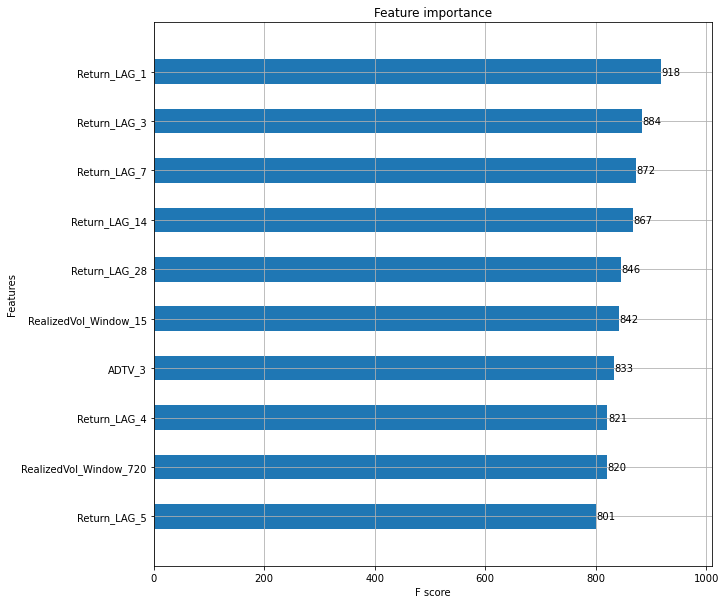

Testing Data


array([[12767,  9649],
       [11572,  9212]], dtype=int64)

              precision    recall  f1-score   support

           0       0.52      0.57      0.55     22416
           1       0.49      0.44      0.46     20784

    accuracy                           0.51     43200
   macro avg       0.51      0.51      0.51     43200
weighted avg       0.51      0.51      0.51     43200



In [93]:
# Post VIF fit
_trainX = _Traindf.drop(['date', 'time', 'Actual_Y'] + dropcindex, axis=1)
_trainy = _Traindf['Actual_Y']
_testX = _Testdf.drop(['date', 'time', 'Actual_Y'] + dropcindex, axis=1)
_testy = _Testdf['Actual_Y']
fix_params = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', \
              'colsample_bytree': 0.35, 'eta': 0.05, 'max_depth': 5, \
              'n_estimators': 500, 'subsample': 0.45, 'use_label_encoder':False}
xg_reg = xgb.XGBClassifier(**fix_params)
xg_reg.fit(_trainX, _trainy)
print('Training Data')
display(confusion_matrix(_trainy, xg_reg.predict(_trainX)))
print(classification_report(_trainy, xg_reg.predict(_trainX)))
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=10, height=0.5, ax=ax,importance_type='weight')
plt.show()
print('Testing Data')
display(confusion_matrix(_testy, xg_reg.predict(_testX)))
print(classification_report(_testy, xg_reg.predict(_testX)))

In [ ]:
# # XGBoost
# XTrain = _Signal_SOLTrain.drop(['date', 'time', 'Actual_Y'], axis=1)
# yTrain = _Signal_SOLTrain['Actual_Y']
# XTest = _Signal_SOLTest.drop(['date', 'time', 'Actual_Y'], axis=1)
# yTest = _Signal_SOLTest['Actual_Y']

# fix_params = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', \
#               'colsample_bytree': 0.35, 'eta': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.45}

# xg_reg = xgb.XGBClassifier(**fix_params)
# xg_reg.fit(XTrain, yTrain)
# print('Training Data')
# display(confusion_matrix(yTrain, xg_reg.predict(XTrain)))
# print(classification_report(yTrain, xg_reg.predict(XTrain)))
# print('Testing Data')
# display(confusion_matrix(yTest, xg_reg.predict(XTest)))
# print(classification_report(yTest, xg_reg.predict(XTest)))

In [ ]:
# from pactools.grid_search import GridSearchCVProgressBar
# from sklearn.metrics import precision_score, make_scorer

# custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label=1)

# X = _Signal_SOLTrain.drop(['date', 'time', 'Actual_Y'], axis=1)
# y = _Signal_SOLTrain['Actual_Y']

# cv_params = {'eta':[0.04, 0.05, 0.06], 
#              'max_depth':[4, 5, 6],
#              'subsample': [0.4, 0.45, 0.5], 
#              'colsample_bytree':[0.3, 0.35, 0.4],
#              'n_estimators':[25, 50, 100]
#             }
# fix_params = {'objective': 'binary:logistic','eval_metric':'mlogloss', 'use_label_encoder':False}

# gscv = GridSearchCVProgressBar(xgb.XGBClassifier(**fix_params), param_grid=cv_params, cv=5, scoring=custom_scorer,
#                                return_train_score=False, verbose=2)
# gscv.fit(X, y)
# gscv.best_params_

In [ ]:
print(1)